In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("stonad_mottakere_kommune_2010_2022.csv")

In [20]:
df

,aar,kommune_nr,kommune_navn,kjonn_kode,stonad,mottaker_antall
0,2022,1101,Eigersund,K,Dagpenger,103.0
1,2022,1101,Eigersund,K,Arbeidsavklaringspenger,222.0
2,2022,1106,Haugesund,K,Dagpenger,133.0
3,2022,1106,Haugesund,K,Arbeidsavklaringspenger,618.0
4,2022,1108,Sandnes,K,Dagpenger,423.0
...,...,...,...,...,...,...
20027,2021,5443,Båtsfjord,M,Arbeidsavklaringspenger,24.0
20028,2020,5444,Sør-Varanger,M,Arbeidsavklaringspenger,110.0
20029,2021,5444,Sør-Varanger,M,Arbeidsavklaringspenger,116.0
20030,2020,5444,Sør-Varanger,K,Arbeidsavklaringspenger,155.0


In [21]:
numerical_columns = df.select_dtypes(include=[float, int])
max_values = numerical_columns.max()
min_values = numerical_columns.min()
mean_values = numerical_columns.mean()

print("Maximum values for numerical columns:")
print(max_values)

print("\nMinimum values for numerical columns:")
print(min_values)

print("\nMean values for numerical columns:")
print(mean_values)

Maximum values for numerical columns:
aar                2022.0
kommune_nr         5444.0
mottaker_antall    2277.0
dtype: float64

Minimum values for numerical columns:
aar                2010.0
kommune_nr          101.0
mottaker_antall       5.0
dtype: float64

Mean values for numerical columns:
aar                2015.754543
kommune_nr         1699.657997
mottaker_antall     108.596615
dtype: float64


In [24]:
non_numerical_columns = df.select_dtypes(exclude=[float, int])
unique_values_counts = non_numerical_columns.nunique()

print("\nNumber of unique values for non-numerical columns:")
print(unique_values_counts)


Number of unique values for non-numerical columns:
kommune_navn    450
kjonn_kode        4
stonad            2
dtype: int64


In [25]:
df['kjonn_kode'].unique()

array(['K', 'Kvinne', 'M', 'Mann'], dtype=object)

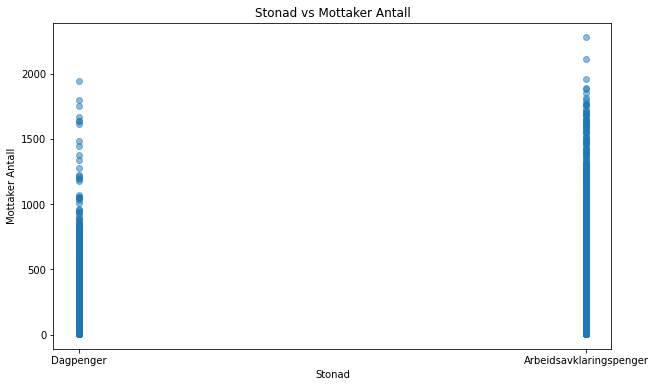

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(df['stonad'], df['mottaker_antall'], alpha=0.5)

# Label the axes and set the plot title
plt.xlabel('Stonad')
plt.ylabel('Mottaker Antall')
plt.title('Stonad vs Mottaker Antall')

# Show the plot
plt.show()

In [17]:
pivot_df = df.pivot_table(index="aar", columns="stonad", values="mottaker_antall", aggfunc="sum")

# Reset the index to have "aar" as a regular column
pivot_df.reset_index(inplace=True)
pivot_df["Total Stonad"] = pivot_df.iloc[:, 1:].sum(axis=1)

<AxesSubplot:xlabel='aar'>

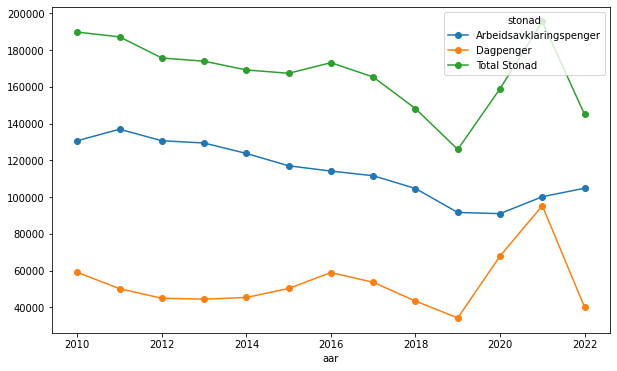

In [18]:
pivot_df.set_index("aar", inplace=True)
pivot_df.plot(kind="line", marker="o", figsize=(10, 6))

In [19]:
pivot_df

stonad,Arbeidsavklaringspenger,Dagpenger,Total Stonad
aar,,,
2010,130681.0,59081.0,189762.0
2011,136933.0,50209.0,187142.0
2012,130662.0,45003.0,175665.0
2013,129437.0,44496.0,173933.0
2014,123740.0,45418.0,169158.0
2015,117027.0,50322.0,167349.0
2016,114156.0,58964.0,173120.0
2017,111632.0,53679.0,165311.0
2018,104672.0,43461.0,148133.0
